# Medicare Fraud - Outpatient Exploratory Data Analysis

Mustapha Mbengue, Peyton Nash, Bradley Stoller, Kyler Rosen

3/9/25

Purpose: Conducts exploratory data analysis on the outpatient data.

# Import Library

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Function Library

In [124]:
def plot_numerical_distributions(df, continuous_vars, logged= False):
    """
    Plot boxplots and histograms for a list of numerical columns in a dataset.
    """
    num_features = len(continuous_vars)

    # Initialize the figure and axes
    fig, axes = plt.subplots(num_features, 2, figsize=(12, 3 * num_features))

    # Ensure correct handling for a single feature
    if num_features == 1:
        axes = np.array(axes).reshape(1, 2)

    # Loop through the numerical features
    for i, feature in enumerate(continuous_vars):
        display_name = str(feature).title()

        # Create boxplot
        if logged:
            sns.boxplot(y= np.log1p(df[feature]), ax=axes[i, 0], width=0.3, color='cornflowerblue')
        else:
            sns.boxplot(y=df[feature], ax=axes[i, 0], width=0.3, color='cornflowerblue') 
        axes[i, 0].set_xticks([])
        axes[i, 0].set_xlabel('Boxplot', fontsize=10)
        axes[i, 0].set_ylabel(display_name, fontsize=10)
        axes[i, 0].set_title(f'Boxplot of Log Transformed {display_name}', fontweight='bold', fontsize=12)

        # Create histogram
        if logged:
            sns.histplot(np.log1p(df[feature]), bins=30, kde=True, ax=axes[i, 1], color='cornflowerblue')
            axes[i, 1].set_xlabel(display_name, fontsize=10)
            axes[i, 1].set_ylabel('Count', fontsize=10)
            axes[i, 1].set_title(f'Histogram of Log Transformed {display_name}', fontweight='bold', fontsize=12)
        else:
            sns.histplot(df[feature], bins=30, kde=True, ax=axes[i, 1], color='cornflowerblue')
            axes[i, 1].set_xlabel(display_name, fontsize=10)
            axes[i, 1].set_ylabel('Count', fontsize=10)
            axes[i, 1].set_title(f'Histogram of {display_name}', fontweight='bold', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()


def categorical_distribution_analysis(df, df_name, categorical_cols):
    """
    Plot bar graphs and count plots of the categorical columns
    """
    
    # Intialize the axis
    num_cols = len(categorical_cols)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))

    # Loop through the categorical columns for plotting
    for i, col in enumerate(categorical_cols):
        top_categories = df[col].value_counts().nlargest(5)

        # Create bar plot for top 5 categories
        sns.barplot(x=top_categories.index, y=top_categories.values, ax=axes[i, 0], palette="coolwarm")
        axes[i, 0].set_title(f"Top 5 Categories in {col}")
        axes[i, 0].set_xticklabels(axes[i, 0].get_xticklabels(), rotation=45, ha="right")

        # Create count plot for top 5 categories
        sns.countplot(y=df[col], order=df[col].value_counts().index[:10], ax=axes[i, 1], palette="viridis")
        axes[i, 1].set_title(f"Category Distribution in {col}")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Outpatient (labeled) EDA

In [125]:
outpatient_labeled = pd.read_csv('../data/raw/Train_Outpatientdata-1542865627584.csv', parse_dates= ['ClaimStartDt', 'ClaimEndDt'])
outpatient_labeled.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [147]:
outpatient_labeled.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')

Set the numerical and categorical columns to be used in the analysis

In [126]:
num_cols = ['ClaimStartDt', 'ClaimEndDt', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid']

cat_cols = [
    'BeneID', 'ClaimID', 'Provider', 'AttendingPhysician', 'OperatingPhysician',
    'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
    'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
    'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
    'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
    'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
    'ClmProcedureCode_5', 'ClmProcedureCode_6', 'ClmAdmitDiagnosisCode'
]

In [127]:
print("Shape:", outpatient_labeled.shape)
print("\nDataframe Info:")
print(outpatient_labeled.info())

Shape: (517737, 27)

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BeneID                  517737 non-null  object        
 1   ClaimID                 517737 non-null  object        
 2   ClaimStartDt            517737 non-null  datetime64[ns]
 3   ClaimEndDt              517737 non-null  datetime64[ns]
 4   Provider                517737 non-null  object        
 5   InscClaimAmtReimbursed  517737 non-null  int64         
 6   AttendingPhysician      516341 non-null  object        
 7   OperatingPhysician      90617 non-null   object        
 8   OtherPhysician          195046 non-null  object        
 9   ClmDiagnosisCode_1      507284 non-null  object        
 10  ClmDiagnosisCode_2      322357 non-null  object        
 11  ClmDiagnosisCode_3      203257 non-null  object       

In [128]:
# Check missing Values
print('Missing Value Analysis:')
(100 * pd.isnull(outpatient_labeled).sum() / len(outpatient_labeled)).sort_values(ascending=False)

Missing Value Analysis:


ClmProcedureCode_6        100.000000
ClmProcedureCode_5        100.000000
ClmProcedureCode_4         99.999614
ClmProcedureCode_3         99.999227
ClmProcedureCode_2         99.993047
ClmProcedureCode_1         99.968710
ClmDiagnosisCode_10        99.790820
ClmDiagnosisCode_9         97.134066
ClmDiagnosisCode_8         95.574587
ClmDiagnosisCode_7         93.633640
ClmDiagnosisCode_6         90.582864
ClmDiagnosisCode_5         85.640586
OperatingPhysician         82.497484
ClmAdmitDiagnosisCode      79.637345
ClmDiagnosisCode_4         75.741351
OtherPhysician             62.327205
ClmDiagnosisCode_3         60.741264
ClmDiagnosisCode_2         37.737307
ClmDiagnosisCode_1          2.018979
AttendingPhysician          0.269635
ClaimID                     0.000000
InscClaimAmtReimbursed      0.000000
Provider                    0.000000
ClaimEndDt                  0.000000
ClaimStartDt                0.000000
DeductibleAmtPaid           0.000000
BeneID                      0.000000
d

There appear to be significant missing values, but this is mostly in columns where patients are not expected to have values. Such as if they did not need a 6th procedure/claim.

In [129]:
outpatient_labeled[num_cols].describe()

,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,DeductibleAmtPaid
count,517737,517737,517737.000000,517737.000000
mean,2009-06-25 09:29:47.723883008,2009-06-26 19:35:21.692674048,286.334799,2.779233
min,2008-12-12 00:00:00,2008-12-28 00:00:00,0.000000,0.000000
25%,2009-03-28 00:00:00,2009-03-29 00:00:00,40.000000,0.000000
50%,2009-06-23 00:00:00,2009-06-25 00:00:00,80.000000,0.000000
75%,2009-09-22 00:00:00,2009-09-23 00:00:00,200.000000,0.000000
max,2009-12-31 00:00:00,2009-12-31 00:00:00,102500.000000,897.000000
std,NaN,NaN,694.034343,15.785839


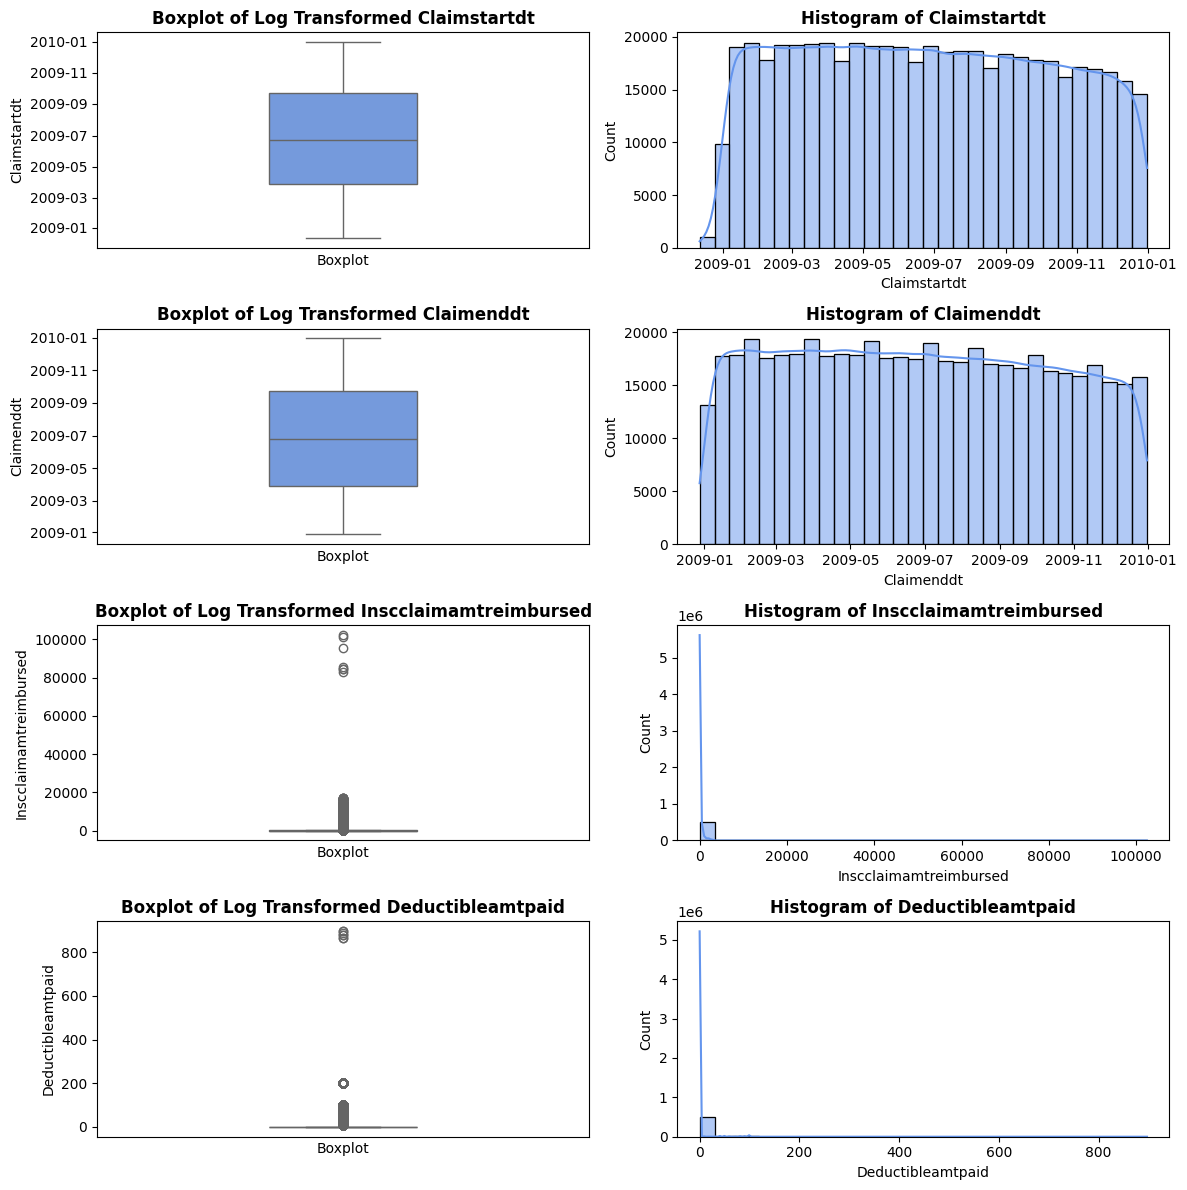

In [130]:
plot_numerical_distributions(outpatient_labeled, num_cols)

The numerical columns (besides the dates) appear to be fairly skewed. We can try log transforming them to see if they appear more Gaussian:

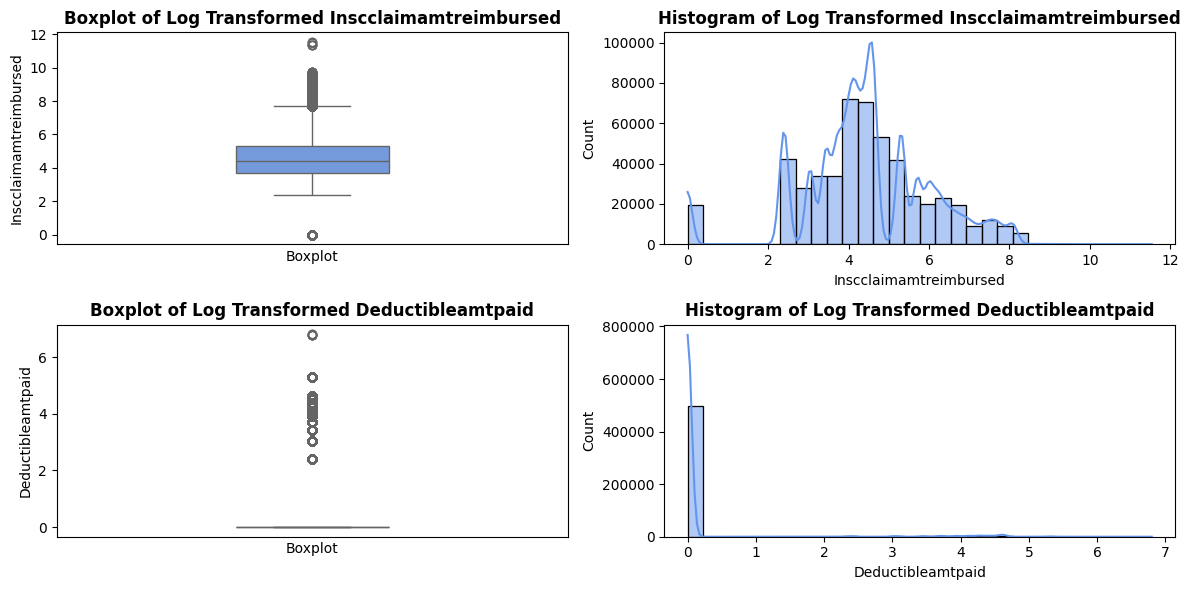

In [131]:
plot_numerical_distributions(outpatient_labeled, ['InscClaimAmtReimbursed', 'DeductibleAmtPaid'], logged= True)

As we can, log transforming the remimbursement amount definitely improved the shape of the distribution, but the deductible amount is still very skewed, even after log transformation.

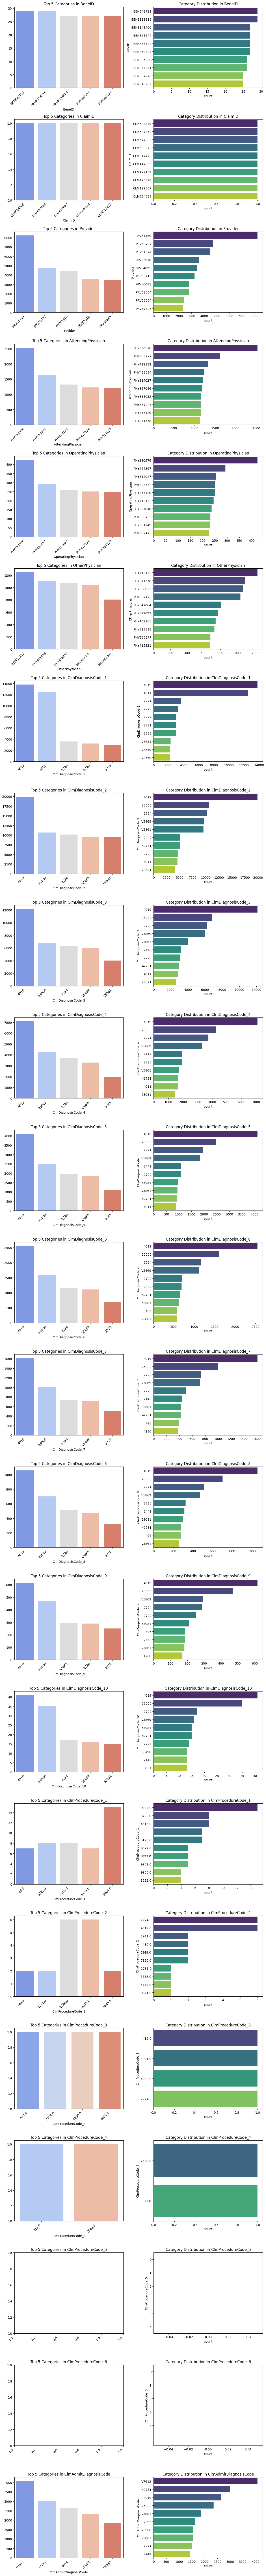

In [132]:
categorical_distribution_analysis(outpatient_labeled, 'Outpatient Labeled', cat_cols)

# Outpatient (unlabeled) EDA

In [133]:
outpatient_unlabeled = pd.read_csv('../data/raw/Test_Outpatientdata-1542969243754.csv', parse_dates= ['ClaimStartDt', 'ClaimEndDt'])
outpatient_unlabeled.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,7248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,58889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5939
4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,NaN,PHY382041,V666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [134]:
print("Shape:", outpatient_unlabeled.shape)
print("\nDataframe Info:")
print(outpatient_unlabeled.info())

Shape: (125841, 27)

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125841 entries, 0 to 125840
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BeneID                  125841 non-null  object        
 1   ClaimID                 125841 non-null  object        
 2   ClaimStartDt            125841 non-null  datetime64[ns]
 3   ClaimEndDt              125841 non-null  datetime64[ns]
 4   Provider                125841 non-null  object        
 5   InscClaimAmtReimbursed  125841 non-null  int64         
 6   AttendingPhysician      125525 non-null  object        
 7   OperatingPhysician      21604 non-null   object        
 8   OtherPhysician          47619 non-null   object        
 9   ClmDiagnosisCode_1      123263 non-null  object        
 10  ClmDiagnosisCode_2      78110 non-null   object        
 11  ClmDiagnosisCode_3      49266 non-null   object       

In [135]:
# Check missing Values
print('Missing Value Analysis:')
(100 * pd.isnull(outpatient_unlabeled).sum() / len(outpatient_unlabeled)).sort_values(ascending=False)

Missing Value Analysis:


ClmProcedureCode_6        100.000000
ClmProcedureCode_5        100.000000
ClmProcedureCode_4        100.000000
ClmProcedureCode_3         99.998411
ClmProcedureCode_2         99.992848
ClmProcedureCode_1         99.972982
ClmDiagnosisCode_10        99.791006
ClmDiagnosisCode_9         97.168649
ClmDiagnosisCode_8         95.604771
ClmDiagnosisCode_7         93.666611
ClmDiagnosisCode_6         90.618320
ClmDiagnosisCode_5         85.723254
OperatingPhysician         82.832304
ClmAdmitDiagnosisCode      79.493965
ClmDiagnosisCode_4         75.786906
OtherPhysician             62.159392
ClmDiagnosisCode_3         60.850597
ClmDiagnosisCode_2         37.929610
ClmDiagnosisCode_1          2.048617
AttendingPhysician          0.251111
ClaimID                     0.000000
InscClaimAmtReimbursed      0.000000
Provider                    0.000000
ClaimEndDt                  0.000000
ClaimStartDt                0.000000
DeductibleAmtPaid           0.000000
BeneID                      0.000000
d

There appear to be significant missing values, but this is mostly in columns where patients are not expected to have values. Such as if they did not need a 6th procedure/claim.

In [136]:
outpatient_unlabeled[num_cols].describe()

,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,DeductibleAmtPaid
count,125841,125841,125841.000000,125841.000000
mean,2009-06-25 02:43:32.611152384,2009-06-26 12:38:47.165232384,288.820496,2.791181
min,2008-12-12 00:00:00,2009-01-01 00:00:00,0.000000,0.000000
25%,2009-03-27 00:00:00,2009-03-29 00:00:00,40.000000,0.000000
50%,2009-06-23 00:00:00,2009-06-24 00:00:00,80.000000,0.000000
75%,2009-09-21 00:00:00,2009-09-23 00:00:00,200.000000,0.000000
max,2009-12-31 00:00:00,2009-12-31 00:00:00,93240.000000,897.000000
std,NaN,NaN,751.028751,16.039935


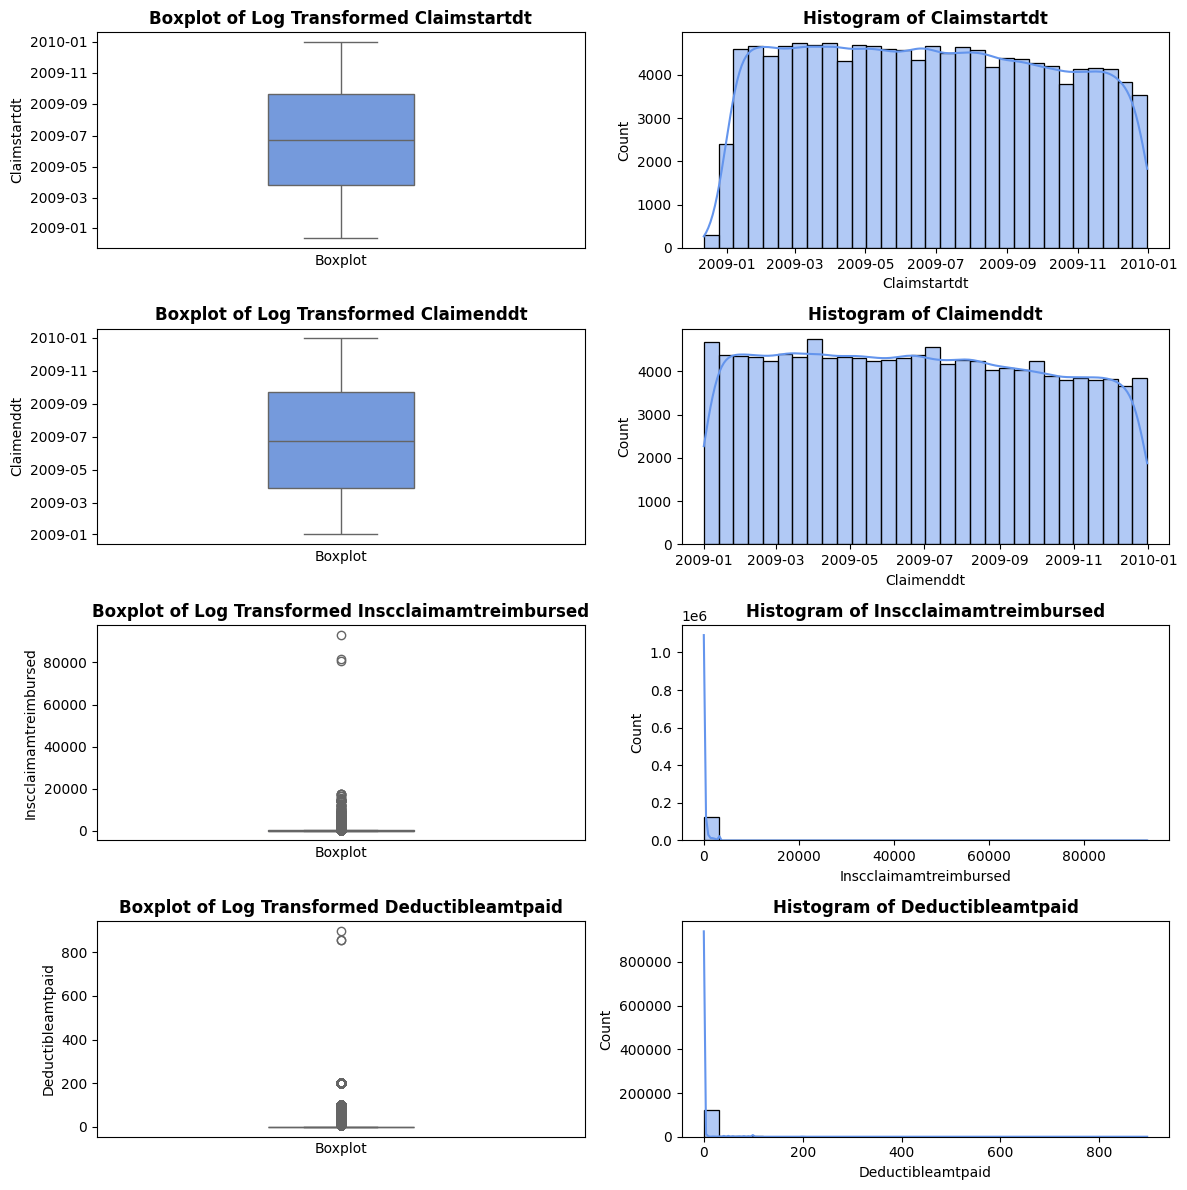

In [137]:
plot_numerical_distributions(outpatient_unlabeled, num_cols)

The numerical columns (besides the dates) appear to be fairly skewed. We can try log transforming them to see if they appear more Gaussian:

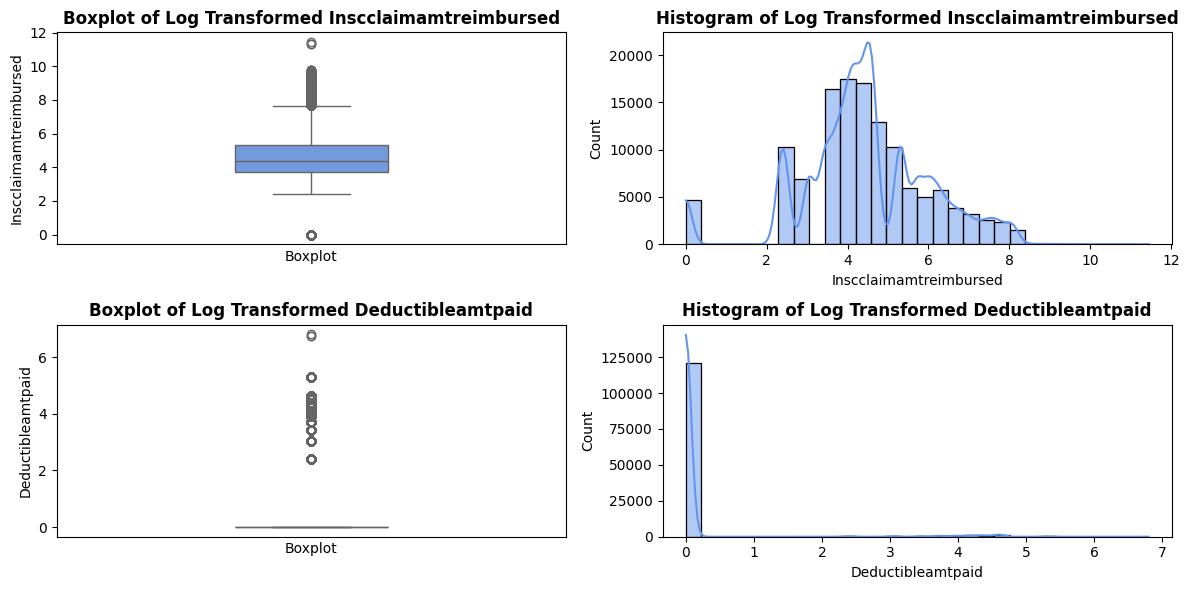

In [138]:
plot_numerical_distributions(outpatient_unlabeled, ['InscClaimAmtReimbursed', 'DeductibleAmtPaid'], logged= True)

As we can, log transforming the remimbursement amount definitely improved the shape of the distribution, but the deductible amount is still very skewed, even after log transformation.

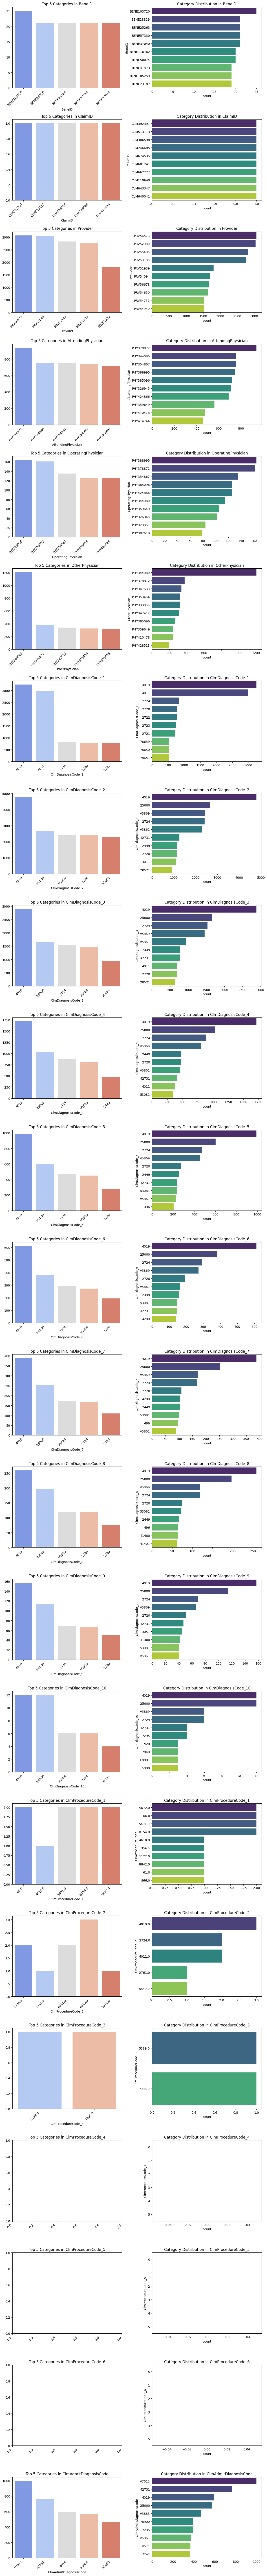

In [139]:
categorical_distribution_analysis(outpatient_unlabeled, 'Outpatient Unlabelled', cat_cols)

# Outpatient (appended) EDA

In [140]:
df_appended = pd.concat([outpatient_labeled, outpatient_unlabeled])

In [141]:
print("Shape:", df_appended.shape)
print("\nDataframe Info:")
print(df_appended.info())

Shape: (643578, 27)

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Index: 643578 entries, 0 to 125840
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BeneID                  643578 non-null  object        
 1   ClaimID                 643578 non-null  object        
 2   ClaimStartDt            643578 non-null  datetime64[ns]
 3   ClaimEndDt              643578 non-null  datetime64[ns]
 4   Provider                643578 non-null  object        
 5   InscClaimAmtReimbursed  643578 non-null  int64         
 6   AttendingPhysician      641866 non-null  object        
 7   OperatingPhysician      112221 non-null  object        
 8   OtherPhysician          242665 non-null  object        
 9   ClmDiagnosisCode_1      630547 non-null  object        
 10  ClmDiagnosisCode_2      400467 non-null  object        
 11  ClmDiagnosisCode_3      252523 non-null  object        
 12

In [142]:
# Check missing Values
print('Missing Value Analysis:')
(100 * pd.isnull(df_appended).sum() / len(df_appended)).sort_values(ascending=False)

Missing Value Analysis:


ClmProcedureCode_6        100.000000
ClmProcedureCode_5        100.000000
ClmProcedureCode_4         99.999689
ClmProcedureCode_3         99.999068
ClmProcedureCode_2         99.993008
ClmProcedureCode_1         99.969545
ClmDiagnosisCode_10        99.790857
ClmDiagnosisCode_9         97.140828
ClmDiagnosisCode_8         95.580489
ClmDiagnosisCode_7         93.640087
ClmDiagnosisCode_6         90.589796
ClmDiagnosisCode_5         85.656750
OperatingPhysician         82.562953
ClmAdmitDiagnosisCode      79.609309
ClmDiagnosisCode_4         75.750259
OtherPhysician             62.294392
ClmDiagnosisCode_3         60.762643
ClmDiagnosisCode_2         37.774908
ClmDiagnosisCode_1          2.024774
AttendingPhysician          0.266013
ClaimID                     0.000000
InscClaimAmtReimbursed      0.000000
Provider                    0.000000
ClaimEndDt                  0.000000
ClaimStartDt                0.000000
DeductibleAmtPaid           0.000000
BeneID                      0.000000
d

There appear to be significant missing values, but this is mostly in columns where patients are not expected to have values. Such as if they did not need a 6th procedure/claim.

In [143]:
df_appended[num_cols].describe()

,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,DeductibleAmtPaid
count,643578,643578,643578.000000,643578.000000
mean,2009-06-25 08:10:21.575007232,2009-06-26 18:13:54.427528704,286.820836,2.781570
min,2008-12-12 00:00:00,2008-12-28 00:00:00,0.000000,0.000000
25%,2009-03-27 00:00:00,2009-03-29 00:00:00,40.000000,0.000000
50%,2009-06-23 00:00:00,2009-06-25 00:00:00,80.000000,0.000000
75%,2009-09-22 00:00:00,2009-09-23 00:00:00,200.000000,0.000000
max,2009-12-31 00:00:00,2009-12-31 00:00:00,102500.000000,897.000000
std,NaN,NaN,705.540943,15.835832


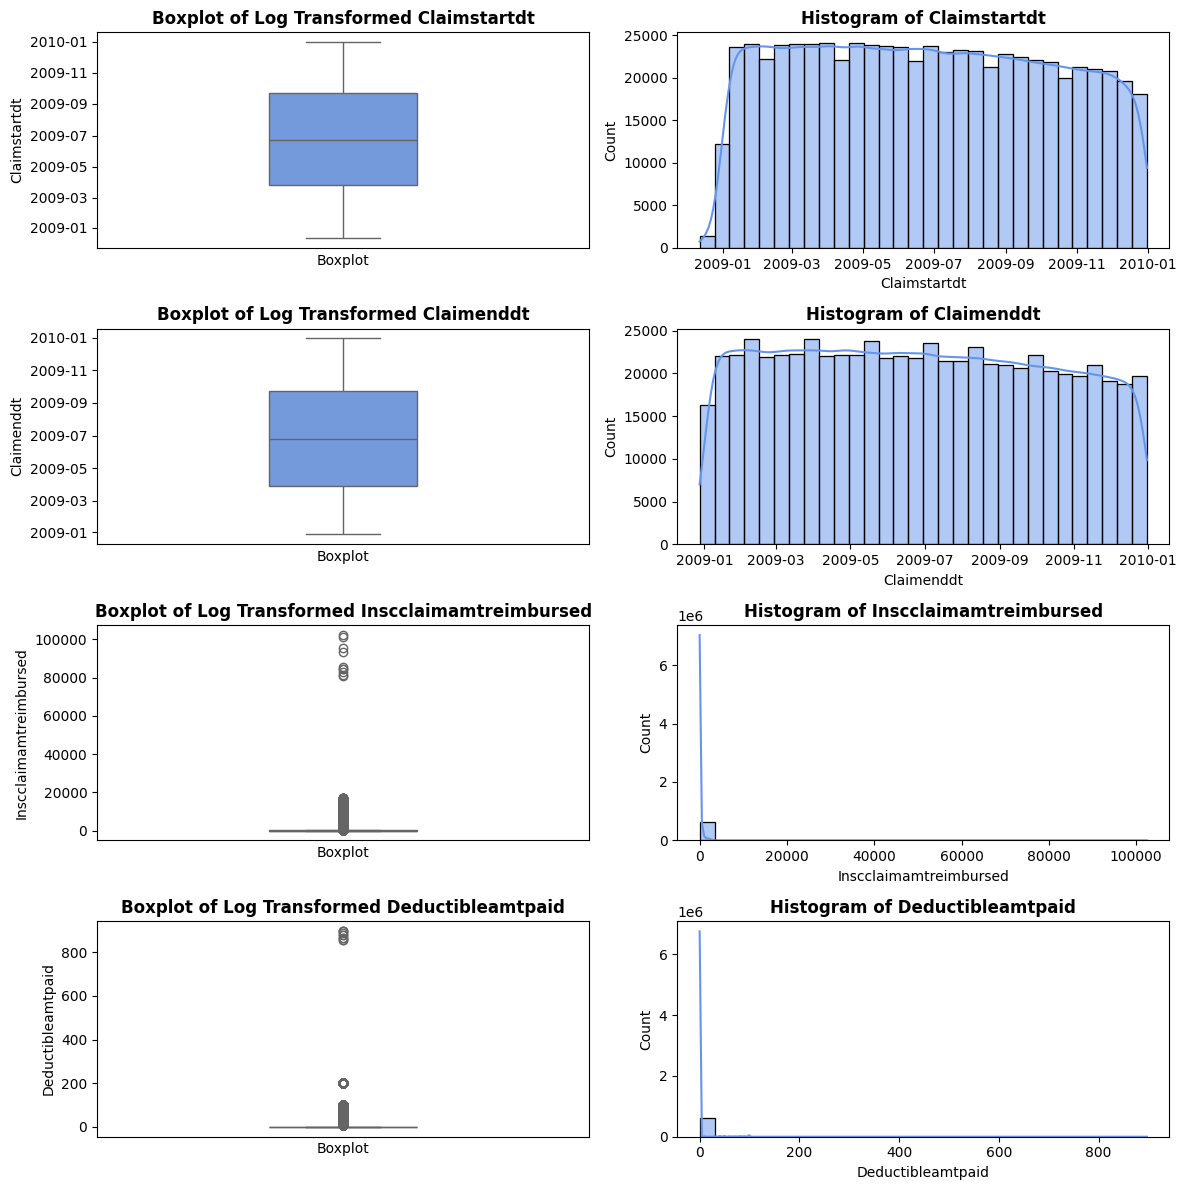

In [144]:
plot_numerical_distributions(df_appended, num_cols)

The numerical columns (besides the dates) appear to be fairly skewed. We can try log transforming them to see if they appear more Gaussian:

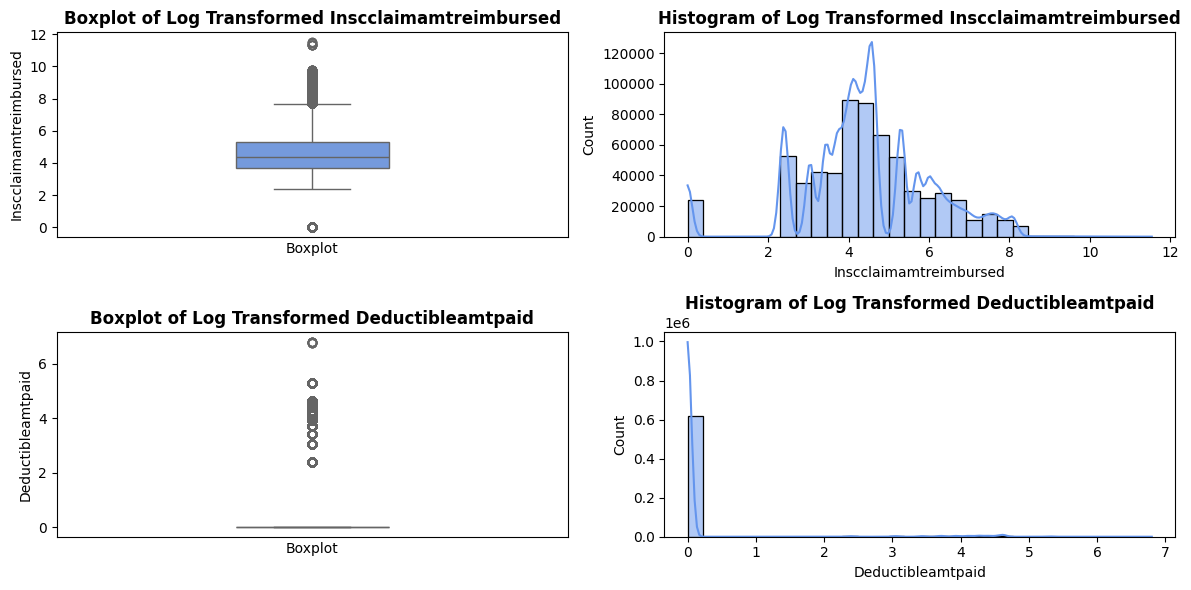

In [145]:
plot_numerical_distributions(df_appended, ['InscClaimAmtReimbursed', 'DeductibleAmtPaid'], logged= True)

As we can, log transforming the remimbursement amount definitely improved the shape of the distribution, but the deductible amount is still very skewed, even after log transformation.